# Signature analysis with mSigAct

First, check notebook `Selection_of_signatures_with_combinatorial_refitting.ipynb`

In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from tqdm.notebook import tqdm

import matplotlib

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.transparent'] = True

from pandas.api.types import CategoricalDtype

## Relative to mappable genome

In [2]:
%run ../mutational_profiles/scripts/functions_genome_contexts.py

keys = list(mut_key_gen())
mut_keys = [key[0]+key[1] for key in keys]
# context_genome_dict = dict(zip(mut_keys,genome_context_counts))

cols_dict = {'Subtype':'subtype','Context':'context','Sample':'sample','Mut Depth':'mut_depth',
             'Background Count':'BackgroundCount','Mean':'mean','Lower CI':'lower_ci',
            'Upper CI':'upper_ci'}

def make_channels (row):
    mut = row['subtype']
    context = row['context']
    channel = context[0]+'['+mut+']'+context[2]
    return channel

def make_dictionary (df1,tool_format='deconstruct',context_genome_dict=None):
    
    if tool_format == 'deconstruct':        
    
        df1['channels'] = df1.apply(lambda row: make_channels(row),axis=1)
        df1['alt'] = df1['subtype'].str.split('>',expand=True)[1]
        df1['channels2'] = df1['context'] + df1['alt']
        
    elif tool_format == 'msigact':
        df1['alt'] = df1['subtype'].str.split('>',expand=True)[1]
        df1['channels'] = df1['context'] + df1['alt']
        df1['channels2'] = df1['channels']
    else:
        print('Another format?')
    
    #Make dictionary with scaled counts to the panel
    if context_genome_dict != None:   
        
        #Transform decimal values (probabilities) as counts, with the proportion of triplet occurences in the genome
        df1['counts'] = df1.apply(lambda row: int(round(row['mean']*context_genome_dict[row['channels2']],0)),axis=1)
    else:
        df1['counts'] = df1['mut_depth']        
    dictionary = dict(zip(df1['channels'],df1['counts']))
    return dictionary

In [3]:
#prepare genome ccounts to mappable genome
mappable_genome_by_chunk_dict = json.load(open('../mutational_profiles/data/hg38_1000kb_bin.filtered.mappable_positions.autosomes.trinuc_per_bin.json','rb'))
contexts = mappable_genome_by_chunk_dict['chr1:3000000-4000000'].keys()
all_contexts_dict = { context:0 for context in contexts}

for chunk in tqdm(mappable_genome_by_chunk_dict.keys()):
    contexts_dict = mappable_genome_by_chunk_dict[chunk]
    for context in contexts:
        all_contexts_dict[context] = contexts_dict[context] + all_contexts_dict[context]
        
map_genome_contexts_dict = {}
for key in keys:
    context = key[0]
    mut = key[1]
    map_genome_contexts_dict[context+mut] = all_contexts_dict[context]
map_genome_contexts_dict   

{'ACAA': 83603206,
 'ACCA': 46367544,
 'ACGA': 9335552,
 'ACTA': 67155246,
 'CCAA': 73859423,
 'CCCA': 52121678,
 'CCGA': 9622701,
 'CCTA': 71755035,
 'GCAA': 58743061,
 'GCCA': 46601530,
 'GCGA': 8245427,
 'GCTA': 56910121,
 'TCAA': 81205501,
 'TCCA': 62456262,
 'TCGA': 8043982,
 'TCTA': 92070619,
 'ACAG': 83603206,
 'ACCG': 46367544,
 'ACGG': 9335552,
 'ACTG': 67155246,
 'CCAG': 73859423,
 'CCCG': 52121678,
 'CCGG': 9622701,
 'CCTG': 71755035,
 'GCAG': 58743061,
 'GCCG': 46601530,
 'GCGG': 8245427,
 'GCTG': 56910121,
 'TCAG': 81205501,
 'TCCG': 62456262,
 'TCGG': 8043982,
 'TCTG': 92070619,
 'ACAT': 83603206,
 'ACCT': 46367544,
 'ACGT': 9335552,
 'ACTT': 67155246,
 'CCAT': 73859423,
 'CCCT': 52121678,
 'CCGT': 9622701,
 'CCTT': 71755035,
 'GCAT': 58743061,
 'GCCT': 46601530,
 'GCGT': 8245427,
 'GCTT': 56910121,
 'TCAT': 81205501,
 'TCCT': 62456262,
 'TCGT': 8043982,
 'TCTT': 92070619,
 'ATAA': 88390892,
 'ATCA': 54998890,
 'ATGA': 76404531,
 'ATTA': 106335106,
 'CTAA': 53988655,
 'CT

In [6]:

def create_snv_class(df):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    x = df['context']

    if x[1] in pyr:
        out = '{}{}{}{}'.format(x[0], x[1], x[2], df['alt'])
    else:
        out = '{}{}{}{}'.format(rev[x[2]], rev[x[1]], rev[x[0]], rev[df['alt']])

    return out

def context_pyr(x):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    if x[1] in pyr:
        return x
    else:
        return rev[x[2]]+rev[x[1]]+rev[x[0]]
    
def prepare_count_table(path):
    df = pd.read_csv(path,sep='\t')
    df['vaf'] = df['alt_depth'] / df['depth']
    df = df.rename(columns={'context':'context2'})
    df['context'] = df['context2'].apply(lambda x: context_pyr (x)) #transform all triplets into pyr perspective  
    
    path2 = path.replace('.mut','.genome.mut')
    df2 = pd.read_csv(path2,sep='\t')
    df2 = df2.rename(columns={'context':'context2'})
    df2['context'] = df2['context2'].apply(lambda x: context_pyr (x))  #trasnform all triplets into pyr perspective  
    df2 = df2[['context','depth']].groupby('context',as_index=False).sum() #sum all the times a triplet has been observed
    depth_dict = dict(zip(df2['context'],df2['depth']))

    df = df[(df['vaf']<0.35)&(df['variation_type']=='snv')] #filter by vaf<0.35 and snv
    df['channels'] = df.apply(create_snv_class, axis=1)

    cat_type = CategoricalDtype(categories=mut_keys, ordered=True)
    df['channels'] = df['channels'].astype(cat_type)
    df1 = df[['channels','subtype']].groupby(['channels'],as_index=False).count() #count mutations (not sum) to know number of unique muts
    df1 = df1.rename(columns={'subtype':'mut_count'})
    df1['context'] = df1['channels'].apply(lambda x: x[:-1])
    df1['subtype'] = df1['channels'].apply(lambda x: x[1]+'>'+x[3])
    df1['BackgroundCount'] = df1['context'].map(depth_dict)
    df1['mean'] = df1['mut_count'] / df1['BackgroundCount']
    return df1

## Prepare count matrix

In [7]:
sigs_dict = json.load(open('./msigact/sigs_per_sample.json','rb'))

In [8]:
sigs_dict

{'AU2198': ['SBS1', 'SBS2', 'SBS31', 'SBS45'],
 'AU2199': ['SBS1', 'SBS2', 'SBS18', 'SBS31', 'SBS40', 'SBS45'],
 'AU2200': ['SBS1', 'SBS2', 'SBS5', 'SBS18', 'SBS31', 'SBS45'],
 'AU2202': ['SBS1', 'SBS2', 'SBS18', 'SBS31', 'SBS40'],
 'AZ4609': ['SBS5', 'SBS18', 'SBS31', 'SBS40', 'SBS45'],
 'AZ4610': ['SBS5', 'SBS31', 'SBS40', 'SBS45'],
 'AZ4611': ['SBS5', 'SBS31', 'SBS40', 'SBS45'],
 'AZ4612': ['SBS1', 'SBS31', 'SBS40'],
 'AZ4613': ['SBS2', 'SBS13', 'SBS31', 'SBS40'],
 'AZ4614': ['SBS5', 'SBS18', 'SBS31', 'SBS40'],
 'AZ6342': ['SBS5', 'SBS18', 'SBS31', 'SBS40'],
 'AZ6371': ['SBS1', 'SBS18', 'SBS31', 'SBS40']}

In [9]:
print('Proportion of mappable genome triplets')
matrix_df = pd.DataFrame()
path = '../mutational_profiles/output_dnanexus/'
for file in os.listdir(path):
    if file.endswith('variant-calls.mut'):
        df1 = prepare_count_table(path+file)
        dictionary1 = make_dictionary(df1,'msigact',map_genome_contexts_dict)
        sample = file.split('.1')[0]
        if sample.startswith('CHp'):
            names_dict = {'CHp_39_T0':'AZ6342','CHp_38_T0':'AZ6371'}
            sample = names_dict[sample]
        df1 = pd.DataFrame.from_dict(dictionary1,orient='index',columns=[sample])
        df1 = df1.T
        matrix_df = pd.concat([matrix_df,df1])
matrix_df.sort_index(inplace=True)
matrix_df = matrix_df.T
selected_samples = sigs_dict.keys()
matrix_df = matrix_df[selected_samples]
matrix_df

Proportion of mappable genome triplets


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,AU2198,AU2199,AU2200,AU2202,AZ4609,AZ4610,AZ4611,AZ4612,AZ4613,AZ4614,AZ6342,AZ6371
ACAA,8,33,6,4,19,20,12,32,10,11,5,0
ACCA,11,11,2,3,21,20,11,0,0,9,4,3
ACGA,9,24,16,4,5,5,6,0,13,6,3,2
ACTA,0,5,16,2,30,14,9,6,10,10,6,0
CCAA,18,47,10,1,17,9,13,12,0,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
GTTG,0,0,2,1,3,4,0,12,5,2,2,0
TTAG,0,0,2,1,4,7,2,7,0,2,0,0
TTCG,0,0,4,1,12,2,3,6,9,2,1,0
TTGG,0,0,4,0,5,4,0,12,0,0,0,0


Text(0.5, 1.0, 'Number of mutations\nMappable genome scaled')

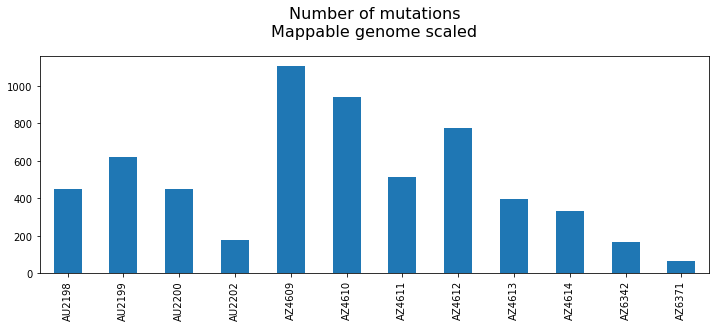

In [14]:
matrix_df.sum().plot(kind='bar',figsize=(12,4))
plt.title('Number of mutations\nMappable genome scaled',size=16,pad=20)

In [127]:
#save matrix per sample in each folder
path = './msigact/'

for sample in matrix_df.columns:
    if not os.path.exists(path+sample):
        os.mkdir(path+sample)
    matrix_df[sample].to_csv(path+sample+'/count_matrix.tsv',sep='\t')

The code is executed with qmaps.  
Check this notebook: `./qmap_msigact.ipynb`

## Results

In [15]:
path = './msigact/'

folders = [folder for folder in os.listdir(path)if folder.startswith('A')]

SBS31_pvals = {}
SBS35_pvals = {}
SBS31_df = pd.DataFrame()
SBS35_df = pd.DataFrame()
for sample in folders:
    df = pd.read_csv(path+sample+'/SBS31/results.count_matrix.tsv.mSigAct.SBS31.tsv',sep='\t')
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={'index':'sample_id'})
    df['sample_id'] = [sample]
    
    df['pval'] = df['pval'].round(4)
    pvals_dict = dict(zip(df['sample_id'],df['pval']))
    SBS31_pvals.update(pvals_dict)
    sigs_cols =[col for col in df.columns if col.startswith('SBS')]
    df = df[['sample_id']+sigs_cols]
    df = df.set_index('sample_id')
    SBS31_df = pd.concat([SBS31_df,df])
    
    df = pd.read_csv(path+sample+'/SBS35/results.count_matrix.tsv.mSigAct.SBS35.tsv',sep='\t')
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={'index':'sample_id'})
    df['sample_id'] = [sample]
    df['pval'] = df['pval'].round(5)
    pvals_dict = dict(zip(df['sample_id'],df['pval']))
    SBS35_pvals.update(pvals_dict)
    sigs_cols =[col for col in df.columns if col.startswith('SBS')]
    df = df.set_index('sample_id')
    SBS35_df = pd.concat([SBS35_df,df])
# SBS31_df = SBS31_df.reindex(samples_id)
# SBS35_df = SBS35_df.reindex(samples_id)
SBS31_df.fillna(0,inplace=True)
SBS31_df = SBS31_df[['SBS1','SBS2','SBS5','SBS13','SBS18','SBS40','SBS45','SBS31']]
SBS35_df.fillna(0,inplace=True)
SBS35_df = SBS35_df[['SBS1','SBS2','SBS5','SBS13','SBS18','SBS40','SBS45','SBS35']]

In [16]:
SBS31_df

,SBS1,SBS2,SBS5,SBS13,SBS18,SBS40,SBS45,SBS31
sample_id,,,,,,,,
AU2198,24.976048,22.018771,0.000000,0.0,0.000000,0.000000,131.877055,269.128127
AU2199,0.000000,53.814437,0.000000,0.0,530.139260,0.000000,0.000000,35.046304
AU2200,13.903467,12.384124,207.714362,0.0,99.875719,0.000000,78.823444,34.298884
AU2202,12.410012,0.000000,0.000000,0.0,42.862809,102.964656,0.000000,18.762523
AZ4609,0.000000,0.000000,263.598884,0.0,235.830685,422.591756,0.000000,183.978674
AZ4610,0.000000,0.000000,238.573374,0.0,0.000000,346.897460,119.276185,237.252982
AZ4611,0.000000,0.000000,198.328457,0.0,0.000000,144.365381,70.154947,100.151215
AZ4612,28.012395,0.000000,0.000000,0.0,0.000000,641.733676,0.000000,106.253928
AZ4613,0.000000,18.440010,0.000000,0.0,0.000000,262.810710,0.000000,116.749280


In [18]:
def color_sigs (sigs):

    colors_dict = {}
    colors_list = []
    greys = ['gainsboro','darkgrey','gray','lightgrey','lightgray','silver','dimgrey','dimgray','slategrey']
    i = 0
    for sig in sigs:
        if 'potential' in sig:
            color = greys[i]
            i+=1
        elif 'SBS1-' in sig or sig=='SBS1':
            color = 'orange'
        elif 'SBS2-' in sig or sig=='SBS2':
            color = 'olive'
        elif 'SBS3-' in sig or sig=='SBS3':
            color = 'mediumpurple'
        elif 'SBS5-' in sig or sig=='SBS5':
            color = 'skyblue'
        elif 'SBS7a' in sig:
            color = 'teal'
        elif 'SBS12' in sig:
            color = 'seagreen'
        elif 'SBS13' in sig:
            color = 'purple'
        elif 'SBS17b' in sig:
            color = 'pink'
        elif 'SBS18' in sig:
            color = 'royalblue'
        elif 'SBS31' in sig:
            color = 'firebrick'
        elif 'SBS32' in sig:
            color = 'plum'
        elif 'SBS35' in sig:
            color = 'lightcoral'
        elif 'SBS40' in sig:
            color = 'turquoise'
        elif 'SBS60' in sig:
            color = 'darkseagreen'
        else:
            color = greys[i]
            i+=1
            pass
        colors_dict[sig] = color
        colors_list.append(color)
    return colors_dict,colors_list

def plot_fitting (df,title,sigs,labels,ylim,figsize):
    
    colors_dict,colors_list = color_sigs(sigs)
    
    #make plot
    df.plot(kind='bar', stacked=True, figsize=figsize,color=colors_list,edgecolor='white')
    plt.grid(False)
    
    plt.title(title,size=20,pad=20)
    

    plt.legend(title='Signatures', bbox_to_anchor=(1, 1), loc='upper left',prop={'size': 14})
    
    plt.tick_params(left = False,bottom=False)
    #y-axis
    plt.ylabel('Number of mutations',size=18)
    plt.ylim(0,ylim)
    
    #x-axis
    plt.xlabel('')
    ticks = range(0,len(df))
    plt.xticks(ticks, labels, rotation=0,size=16,ha='center')

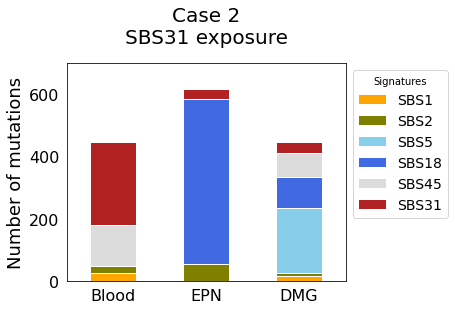

In [19]:
selected_samples = ['AU2198','AU2199','AU2200']
df = SBS31_df[SBS31_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['Blood','EPN','DMG']
title = 'Case 2\nSBS31 exposure'
ylim=700
figsize = (5,4)
plot_fitting(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,800,200),size=16)
plt.savefig('./figures_paper/case2_sbs31_relative_exposures.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
plt.show()


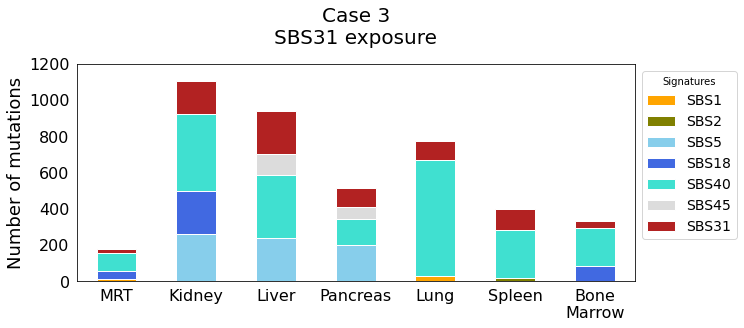

In [20]:
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
df = SBS31_df[SBS31_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['MRT', 'Kidney','Liver','Pancreas','Lung','Spleen','Bone\nMarrow']
title = 'Case 3\nSBS31 exposure'
ylim=1200
figsize = (10,4)
plot_fitting(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,1300,200),size=16)
plt.savefig('./figures_paper/case3_sbs31_relative_exposures.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


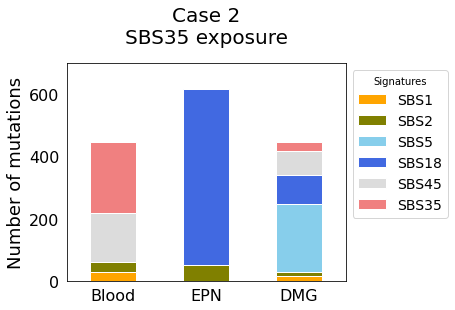

In [21]:
selected_samples = ['AU2198','AU2199','AU2200']
df = SBS35_df[SBS35_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['Blood', 'EPN','DMG']
title =  'Case 2\nSBS35 exposure'
ylim=700
figsize = (5,4)
plot_fitting(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,800,200),size=16)
plt.savefig('./figures_paper/case2_sbs35_fitting.png',dpi=300, format='png',transparent=True,bbox_inches='tight')



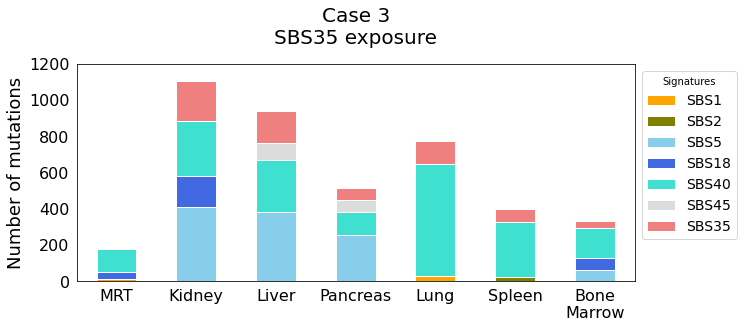

In [22]:
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
df = SBS35_df[SBS35_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['MRT', 'Kidney','Liver','Pancreas','Lung','Spleen','Bone\nMarrow']
title = 'Case 3\nSBS35 exposure'
ylim=1200
figsize = (10,4)
plot_fitting(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,1300,200),size=16)
plt.savefig('./figures_paper/case3_sbs35_fitting.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

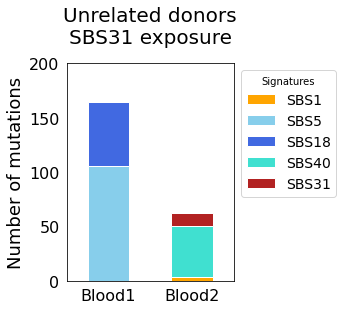

In [23]:
selected_samples = ['AZ6342','AZ6371']
df = SBS31_df[SBS31_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['Blood1', 'Blood2']
title =  'Unrelated donors\nSBS31 exposure'
ylim=200
figsize = (3,4)
plot_fitting(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,210,50),size=16)
plt.savefig('./figures_paper/NonTreatedBloods_sbs31_fitting.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


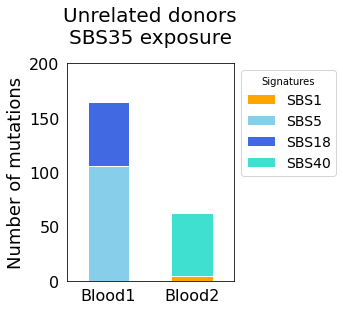

In [24]:
selected_samples = ['AZ6342','AZ6371']
df = SBS35_df[SBS35_df.index.isin(selected_samples)]
df = df.loc[:, (df != 0).any(axis=0)]
sigs = df.columns.tolist()
labels = ['Blood1', 'Blood2']
title =  'Unrelated donors\nSBS35 exposure'
ylim=200
figsize = (3,4)
plot_fitting(df,title,sigs,labels,ylim,figsize=figsize)
plt.yticks(range(0,210,50),size=16)
plt.savefig('./figures_paper/NonTreatedBloods_sbs35_fitting.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


## Plots with confidence intervals
The confidence intervals are calculated in ```./test_sbs31_specificity_and_cnofidence_intervals.ipynb```.\
First execute that notebook, then come back here and continue.

In [52]:
samples_dict['AU2198'] = 'Case2_blood'
samples_dict['AU2199'] = 'Case2_epn'
samples_dict['AU2200'] = 'Case2_dmg'
samples_dict['AU2202'] = 'Case3_mrt'
samples_dict['AZ4609'] = 'Case3_kidney'
samples_dict['AZ4610'] = 'Case3_liver'
samples_dict['AZ4611'] = 'Case3_pancreas'
samples_dict['AZ4612'] = 'Case3_lung'
samples_dict['AZ4613'] = 'Case3_spleen'
samples_dict['AZ4614'] = 'Case3_bone_marrow'
samples_dict['AZ6342'] = 'Unrelated1'
samples_dict['AZ6371'] = 'Unrelated2'
samples_dict

{'AU2202': 'Case3_mrt',
 'AZ4609': 'Case3_kidney',
 'AZ4610': 'Case3_liver',
 'AZ4611': 'Case3_pancreas',
 'AZ4612': 'Case3_lung',
 'AZ4613': 'Case3_spleen',
 'AZ4614': 'Case3_bone_marrow',
 'AZ4663': 'Unrelated1',
 'AZ4671': 'Unrelated2',
 'AU2198': 'Case2_blood',
 'AU2199': 'Case2_epn',
 'AU2200': 'Case2_dmg',
 'AZ6342': 'Unrelated1',
 'AZ6371': 'Unrelated2'}

In [47]:
import matplotlib.lines as mlines

In [48]:
file = './confidence_intervals/ci_sbs31.json'
ci_sbs31_dict = json.load(open(file,'rb'))
file = './confidence_intervals/ci_aging.json'
ci_aging_dict = json.load(open(file,'rb'))

In [49]:
ci_aging_dict

{'AQ5187_vs_AQ5175': [1020, 1251],
 'AU2198': [22, 28],
 'AZ4609': [630, 730],
 'AZ4610': [530, 638],
 'AZ4611': [309, 376],
 'AZ4612': [606, 726],
 'AZ4613': [222, 297],
 'AZ4614': [188, 231],
 'AZ6342': [86, 105],
 'AZ6371': [37, 57]}

In [50]:
def small_barplot (SBS31_df,selected_sample,figsize=(1,2),ylim=400,x_val1=150,x_val2=150,range_val=200):
    print(selected_sample)
    s = selected_sample[0]
    aging_sigs = ['SBS1','SBS5','SBS40']
    df = SBS31_df[SBS31_df.index.isin(selected_sample)]
    df['aging_sigs'] = df[aging_sigs].sum(axis=1)
    df = df[['SBS31','aging_sigs']]
    sigs = df.columns.tolist()
    labels = []
    title = ''
    xlabel=''
    ylabel='Number of\nmutations'
    loc=-80
    legend=False

    rotation_xtick=0
    rotation_pvals=0
    ha='center'

    ci_low = [ df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0] for s in selected_sample]
    ci_high = [ ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0] for s in selected_sample]

    horizontal_line_width = 0.04

    fig, ax = plt.subplots(figsize=figsize)

    for x,val in enumerate(df['SBS31'].tolist()):
        if s in ['AZ6342','AZ6371']:
            ax.plot(x, 0, 'o',color='white',markersize=10)
        else:
            pos = x
            left = pos - horizontal_line_width / 2
            top = val + ci_high[x]
            right = pos + horizontal_line_width / 2
            bottom = val - ci_low[x]
            ax.bar(pos, val, color='firebrick',width=0.1,edgecolor='firebrick')
            ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
            ax.plot([left, right], [top, top], color='k',linewidth=1.5)
            ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    ci_low = [ df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0] for s in selected_sample]
    ci_high = [ ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0] for s in selected_sample]

    for x,val in enumerate(df['aging_sigs'].tolist()):
        pos = x +0.2
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        ax.bar(pos, val, color='cornflowerblue',width=0.1,edgecolor='cornflowerblue')
        ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        ax.plot([left, right], [top, top], color='k',linewidth=1.5)
        ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    #df.plot(kind='scatter', stacked=True, figsize=figsize,color=colors_list,legend=legend,yerr = [ci_low, ci_high],capsize=6)
    plt.title(title,size=20,pad=20)
    plt.margins(0.22,0)

    #y-axis
    plt.ylabel(ylabel,size=14)
    plt.ylim(0,ylim)

    #x-axis
    plt.xlabel(xlabel)
    ticks = range(0,len(df))
    plt.xticks(ticks,[])
    plt.yticks(np.arange(0, ylim+100, range_val),size=14)

    for i, v in enumerate(df['SBS31']):
        if s in ['AZ6342','AZ6371']:
            plt.text(i+0.04, x_val1, str(0), color='firebrick', fontweight='normal',ha='center',va='center',size=15)
        else:
            plt.text(i+0.02, v+x_val1, str(int(round(v,0))), color='firebrick', fontweight='normal',ha='center',va='center',size=15)
    
    for i, v in enumerate(df['aging_sigs']):
        plt.text(i+0.2, v+x_val2, str(int(round(v,0))), color='cornflowerblue', fontweight='normal',ha='center',va='center',size=15)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2,length=7)


    ax.grid(False)
    
    sample_id = samples_dict[selected_sample[0]]
    
    plt.savefig('./figures_paper/'+sample_id+'_platinum_vs_aging_num_muts.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
    plt.show()

['AU2198']


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


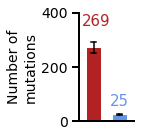

['AZ4609']


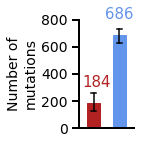

['AZ4610']


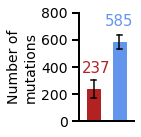

['AZ4611']


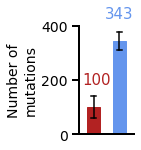

['AZ4612']


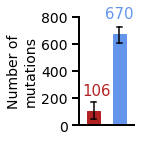

['AZ4613']


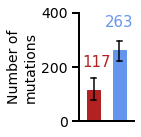

['AZ4614']


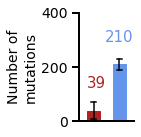

['AZ6342']


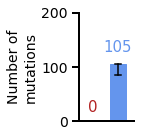

['AZ6371']


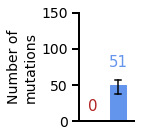

In [53]:
selected_sample = ['AU2198']
small_barplot(SBS31_df,selected_sample,ylim=400,x_val1=100,x_val2=50)
selected_sample = ['AZ4609']
small_barplot(SBS31_df,selected_sample,ylim=800)
selected_sample = ['AZ4610']
small_barplot(SBS31_df,selected_sample,ylim=800)
selected_sample = ['AZ4611']
small_barplot(SBS31_df,selected_sample,ylim=400,x_val1=100,x_val2=100)
selected_sample = ['AZ4612']
small_barplot(SBS31_df,selected_sample,ylim=800)
selected_sample = ['AZ4613']
small_barplot(SBS31_df,selected_sample,ylim=400,x_val1=100,x_val2=100)
selected_sample = ['AZ4614']
small_barplot(SBS31_df,selected_sample,ylim=400,x_val1=100,x_val2=100)
selected_sample = ['AZ6342']
small_barplot(SBS31_df,selected_sample,ylim=200,x_val1=25,x_val2=30,range_val=100)
selected_sample = ['AZ6371']
small_barplot(SBS31_df,selected_sample,ylim=100,x_val1=20,x_val2=30,range_val=50)

### Number of muts Case1 (data from WGS)

In [54]:
path_sbs31_clonals = '../../wgs_analysis/tumor_vs_blood/signature_analysis/msigact/clonals/output_sbs31/results.clonals.matrix.tsv.mSigAct.SBS31.tsv'
case1_df31 = pd.read_csv(path_sbs31_clonals,sep='\t')
case1_df31 = case1_df31[case1_df31.index=='AQ5187_vs_AQ5175']
case1_df31 = case1_df31[['SBS1','SBS5','SBS18','SBS40','SBS31']]
case1_df31

,SBS1,SBS5,SBS18,SBS40,SBS31
AQ5187_vs_AQ5175,153.632827,982.093386,163.31338,0.0,931.960407


In [56]:
samples_dict['AQ5187_vs_AQ5175'] = 'Case1_blood'

['AQ5187_vs_AQ5175']


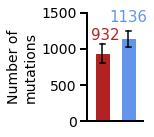

<Figure size 432x288 with 0 Axes>

In [57]:
selected_sample = ['AQ5187_vs_AQ5175']
small_barplot(case1_df31,selected_sample,figsize=(1,2),ylim=1500,x_val1=250,x_val2=300,range_val=500)
plt.savefig('./figures_paper/'+selected_sample[0]+'_platinumn_vs_aging_num_muts.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

## MRT sample from case 3, number of SBS31 vs. other mutations

['AU2202']


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


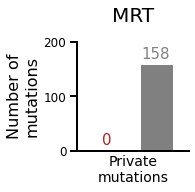

In [58]:
selected_sample=['AU2202']
figsize=(2,2)
ylim=200
x_val1=20
x_val2=20
range_val=100
print(selected_sample)
s = selected_sample[0]
other_sigs = ['SBS1','SBS5','SBS18','SBS40']
df = SBS31_df[SBS31_df.index.isin(selected_sample)]
df['other_sigs'] = df[other_sigs].sum(axis=1)
df = df[['SBS31','other_sigs']]
sigs = df.columns.tolist()
labels = []
title = 'MRT'
xlabel='Private\nmutations'
ylabel='Number of\nmutations'

rotation_xtick=0
rotation_pvals=0

fig, ax = plt.subplots(figsize=figsize)

ax.plot(0, 0, 'o',color='white',markersize=10)

val = df['other_sigs'].tolist()[0]
ax.bar(0.2, val, color='grey',width=0.1,edgecolor='grey')

plt.title(title,size=20,pad=20)
plt.margins(0.22,0)

#y-axis
plt.ylabel(ylabel,size=16)
plt.yticks(np.arange(0, ylim+100, range_val),size=12)
plt.ylim(0,ylim)

#x-axis
plt.xticks([])
plt.xlabel(xlabel,size=14)


plt.text(0.04, x_val1, str(0), color='firebrick', fontweight='normal',ha='center',va='center',size=15)

v = df['other_sigs'][0]
plt.text(0.2, v+x_val2, str(int(round(v,0))), color='grey', fontweight='normal',ha='center',va='center',size=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_linewidth(2) 
ax.spines['bottom'].set_linewidth(2)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=2,length=7)

sample_id = samples_dict[selected_sample[0]]
ax.grid(False)
plt.savefig('./figures_paper/'+sample_id+'_platinumn_vs_aging_num_muts.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
plt.show()

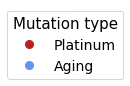

In [59]:
fig, ax = plt.subplots(figsize=(1,1))
plt.xticks([])
plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

sbs31 = mlines.Line2D([], [], color='firebrick', marker='o', linestyle='None',
                          markersize=8, label='Platinum')
aging = mlines.Line2D([], [], color='cornflowerblue', marker='o', linestyle='None',
                          markersize=8, label='Aging')
plt.legend(handles=[sbs31,aging],bbox_to_anchor=(1,0.05,1,1),fontsize=14,title='Mutation type',title_fontsize=15)
plt.savefig('./figures_paper/legend_platinumn_vs_aging.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

## Mutation rates

In [34]:
dates_dict = {'case2':{'DOB':'24-12-2007',
                     'AU2198':'15-04-2011',
                     'AU2199':'13-11-2008',
                     'AU2200':'20-09-2017',
                    'DTT1':'15-11-2008',
                    'DTT2':'17-03-2009'},
             'case3':{'DOB':'08-02-2009',
                    'AU2202':'15-03-2019',
                   'AZ4609':'08-08-2019',
                   'AZ4610':'08-08-2019',
                   'AZ4611':'08-08-2019',
                   'AZ4612':'08-08-2019',
                   'AZ4613':'08-08-2019',
                   'AZ4614':'21-02-2019',
                   'DTT1':'03-08-2010',
                   'DTT2':'05-01-2012'},
             'caseX':{'DOB':'10-11-2003',
                   'AZ6342':'05-12-2017'},
             'caseY':{'DOB':'08-10-2015',
                   'AZ6371':'23-01-2017'}}

def calculate_time(row,samples):
    date_dob = row['DOB']
    day_dob = date_dob.split('-')[0]
    month_dob = date_dob.split('-')[1]
    year_dob = date_dob.split('-')[2]
    for sample in samples:
        date_sample = row[sample]
        day_sample = date_sample.split('-')[0]
        month_sample = date_sample.split('-')[1]
        year_sample = date_sample.split('-')[2]
        
        years_diff = int(year_sample) - int(year_dob)
        months_diff = int(month_sample) - int(month_dob)
        days_diff = int(day_sample) - int(day_dob)
        
        all_years_diff = years_diff + (months_diff/12) + ((days_diff/30)/12)
        
        row[sample+'_t'] = all_years_diff
        
    return row

def time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days):
    dates1_df = pd.DataFrame.from_dict(dates_dict[pt],orient='index')
    dates1_df = dates1_df.T


    dates1_df = dates1_df.apply(lambda row: calculate_time(row,selected_samples),axis=1)
    cols = [sample + '_t' for sample in selected_samples]
    df1 = dates1_df[cols]
    df1 = df1.rename(columns={col:col.split('_t')[0] for col in cols})
    if time_unit == 'days':        
        for sample in selected_samples:
            df1[sample] = df1[sample].apply(lambda x: x*365)
    
    df1 = df1.T
    if time_unit == 'days':
        df1['time_ttmt'] = ttmt_days
    elif time_unit == 'years':
        ttmt_years = ttmt_days/365
        df1['time_ttmt'] = ttmt_years
        
    df1 = df1.rename(columns={0:'time_birth'})

    return df1

In [60]:
selected_samples = ['AU2198','AU2199','AU2200']
pt='case2'
time_unit='days'
ttmt_days = 16
df1 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
pt='case3'
ttmt_days = 8
df2 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AZ6342']
pt='caseX'
ttmt_days = 0
df3 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
selected_samples = ['AZ6371']
pt='caseY'
ttmt_days = 0
df4 = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
time_days_dose_adj_df = pd.concat([df1,df2,df3,df4],ignore_index=False)
time_days_dose_adj_df

,time_birth,time_ttmt
AU2198,1207.541667,16
AU2199,323.430556,16
AU2200,3554.694444,16
AU2202,3687.513889,8
AZ4609,3832.500000,8
AZ4610,3832.500000,8
AZ4611,3832.500000,8
AZ4612,3832.500000,8
AZ4613,3832.500000,8
AZ4614,3663.180556,8


In [61]:
#mutations /day administered
def small_barplot_mut_rate (SBS31_df,selected_sample,figsize=(1,2),ylim=26,yticks = np.arange(-5, ylim, 5), x_val1=1, x_val2=1,log_scale=False):
    aging_sigs = ['SBS1','SBS5','SBS40']
    df = pd.merge(SBS31_df,time_days_dose_adj_df,left_index=True,right_index=True)
    df = df[df.index.isin(selected_sample)]
    df['aging_sigs'] = df[aging_sigs].sum(axis=1)
    df['SBS31_rate'] = df['SBS31'] / df['time_ttmt']
    df['aging_rate'] = df['aging_sigs'] / df['time_birth']
    sigs = df.columns.tolist()
    labels = []
    title = ''
    xlabel=''
    ylabel='Mutation rate\n(muts/day)'
    loc=-80
    legend=False
    rotation_xtick=0
    rotation_pvals=0
    ha='center'
    
    ci_low = []
    ci_high = []
    
    s = selected_sample[0]
    
    horizontal_line_width = 0.04
    fig,ax = plt.subplots(figsize=figsize)
    
    if s in ['AZ6342','AZ6371']:
        pass
    else:
        cl = (df['SBS31'][df.index==s].iloc[0] - ci_sbs31_dict[s][0]) / df['time_ttmt'][df.index==s].iloc[0]
        ch = (ci_sbs31_dict[s][1] - df['SBS31'][df.index==s].iloc[0]) / df['time_ttmt'][df.index==s].iloc[0]
        ci_low.append(cl)
        ci_high.append(ch)

    for x,val in enumerate(df['SBS31_rate'].tolist()):
        if s in ['AZ6342','AZ6371']:
            ax.plot(x, 0, color='white')
        else:
            pos = x
            left = pos - horizontal_line_width / 2
            top = val + ci_high[x]
            right = pos + horizontal_line_width / 2
            bottom = val - ci_low[x]
            ax.bar(pos, val, color='firebrick',width=0.1,edgecolor='firebrick')
            ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
            ax.plot([left, right], [top, top], color='k',linewidth=1.5)
            ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    ci_low = []
    ci_high = []
    for s in selected_sample:
        cl = (df['aging_sigs'][df.index==s].iloc[0] - ci_aging_dict[s][0]) / df['time_birth'][df.index==s].iloc[0]
        ch = (ci_aging_dict[s][1] - df['aging_sigs'][df.index==s].iloc[0]) / df['time_birth'][df.index==s].iloc[0]
        ci_low.append(cl)
        ci_high.append(ch)

    for x,val in enumerate(df['aging_rate'].tolist()):   
        pos = x +0.2
        left = pos - horizontal_line_width / 2
        top = val + ci_high[x]
        right = pos + horizontal_line_width / 2
        bottom = val - ci_low[x]
        ax.bar(pos, val, color='cornflowerblue',width=0.1,edgecolor='cornflowerblue')
        ax.plot([pos, pos], [top, bottom], color='k',linewidth=1.5)
        ax.plot([left, right], [top, top], color='k',linewidth=1.5)
        ax.plot([left, right], [bottom, bottom], color='k',linewidth=1.5)

    plt.title(title,size=20,pad=20)
    plt.margins(0.2,0)

    #y-axis
    plt.ylabel(ylabel,size=14)
    plt.ylim(0,ylim)

    #x-axis
    plt.xlabel(xlabel)
    ticks = range(0,len(df))
    plt.xticks(ticks,[])
    if log_scale==True:
        plt.yscale('log')

    for i, v in enumerate(df['SBS31_rate']):
        if selected_sample[0] in  ['AZ6342','AZ6371']:
            pass
        else:
            plt.text(i+0.1, v+x_val1, str(round(v,2)), color='firebrick', fontweight='normal',ha='center',va='center',size=15)
    for i, v in enumerate(df['aging_rate']):
        plt.text(i+0.25, v+x_val2, str(round(v,2)), color='cornflowerblue', fontweight='normal',ha='center',va='center',size=15)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2,length=7)
    
    sample_id = samples_dict[selected_sample[0]]
    
    ax.grid(False)
    plt.savefig('./figures_paper/'+sample_id+'_mut_rate.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


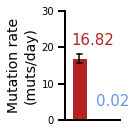

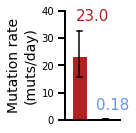

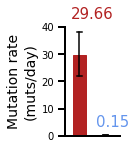

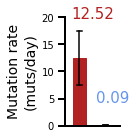

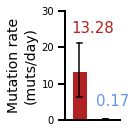

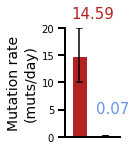

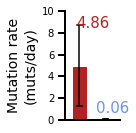

In [62]:
selected_sample = ['AU2198']
small_barplot_mut_rate(SBS31_df,selected_sample,ylim=30,yticks = np.arange(0, 31, 10),x_val1=5,x_val2=5)
selected_sample = ['AZ4609']
small_barplot_mut_rate(SBS31_df,selected_sample,ylim=40,yticks = np.arange(0, 41, 10),x_val1=15,x_val2=5)
selected_sample = ['AZ4610']
small_barplot_mut_rate(SBS31_df,selected_sample,ylim=40,yticks = np.arange(0, 41, 10),x_val1=15,x_val2=5)
selected_sample = ['AZ4611']
small_barplot_mut_rate(SBS31_df,selected_sample,ylim=20,yticks = np.arange(0, 21, 5),x_val1=8,x_val2=5)
selected_sample = ['AZ4612']
small_barplot_mut_rate(SBS31_df,selected_sample,ylim=30,yticks = np.arange(0, 31, 10),x_val1=12,x_val2=5)
selected_sample = ['AZ4613']
small_barplot_mut_rate(SBS31_df,selected_sample,ylim=20,yticks = np.arange(0, 21, 5),x_val1=8,x_val2=5)
selected_sample = ['AZ4614']
small_barplot_mut_rate(SBS31_df,selected_sample,ylim=10,yticks = np.arange(0, 11, 5),x_val1=4,x_val2=1)

### Mut rate Case 1 (data from WGS)

In [63]:
samples_dict

{'AU2202': 'Case3_mrt',
 'AZ4609': 'Case3_kidney',
 'AZ4610': 'Case3_liver',
 'AZ4611': 'Case3_pancreas',
 'AZ4612': 'Case3_lung',
 'AZ4613': 'Case3_spleen',
 'AZ4614': 'Case3_bone_marrow',
 'AZ4663': 'Unrelated1',
 'AZ4671': 'Unrelated2',
 'AU2198': 'Case2_blood',
 'AU2199': 'Case2_epn',
 'AU2200': 'Case2_dmg',
 'AZ6342': 'Unrelated1',
 'AZ6371': 'Unrelated2',
 'AQ5187_vs_AQ5175': 'Case1_blood'}

In [64]:
dates_dict['case1']={'DOB':'08-05-2000',
                     'AQ5181_vs_AQ5175':'13-12-2013',
                   'AQ5187_vs_AQ5175':'23-12-2013'} #second neoplasm date we put the start of the treatment
selected_samples =  ['AQ5181_vs_AQ5175','AQ5187_vs_AQ5175']
pt ='case1'
time_unit ='days'
ttmt_days = [0,4]
case1_time_days_dose_adj_df = time_table (dates_dict,pt,selected_samples,time_unit,ttmt_days)
case1_time_days_dose_adj_df
time_days_dose_adj_df = pd.concat([time_days_dose_adj_df,case1_time_days_dose_adj_df])
time_days_dose_adj_df

,time_birth,time_ttmt
AU2198,1207.541667,16
AU2199,323.430556,16
AU2200,3554.694444,16
AU2202,3687.513889,8
AZ4609,3832.500000,8
AZ4610,3832.500000,8
AZ4611,3832.500000,8
AZ4612,3832.500000,8
AZ4613,3832.500000,8
AZ4614,3663.180556,8


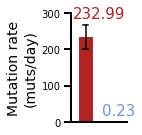

In [65]:
selected_sample = ['AQ5187_vs_AQ5175']
small_barplot_mut_rate(case1_df31,selected_sample,ylim=300,yticks = np.arange(0, 310, 100),x_val1=65,x_val2=30)